In [2]:
%load_ext autoreload
%autoreload 2

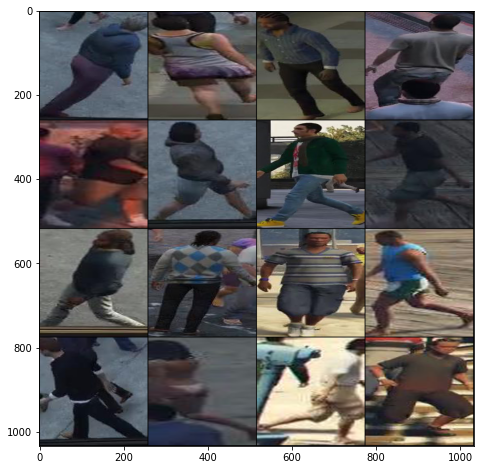

In [15]:
import matplotlib.pyplot as plt
im = plt.imread("./checkpoints/big_idt_prcp/sample/000000.png")
plt.figure(figsize=(8,8))
plt.imshow(im)

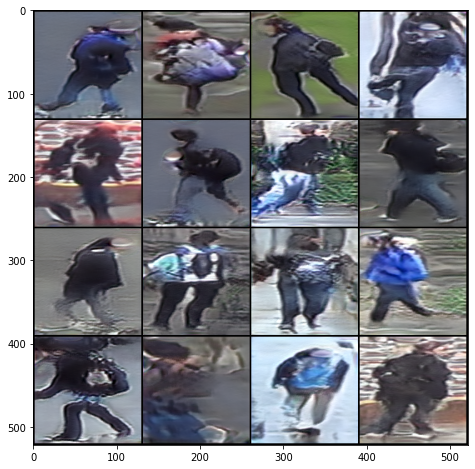

In [39]:
im_num = 50000
import matplotlib.pyplot as plt
im = plt.imread(f"./checkpoints/big_idt_prcp/sample/{str(im_num).zfill(6)}.png")
plt.figure(figsize=(8,8))
plt.imshow(im)

In [148]:
generator = StyledGenerator(512, classes = dataset.total_ids, use_cls = True)

device = torch.device('cpu')

ckpt = torch.load("./checkpoints/test/050000_128.model", map_location=device)

generator.load_state_dict(ckpt['generator'])



<All keys matched successfully>

In [6]:
transform = transforms.Compose(
        [
            #transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5), inplace=True),
        ]
    )

dataset = AlignedDatasetLoader('../../datasets/JTA_parsed', '../../datasets/DukeMTMC', transform, resolution = 64)

In [149]:
bs = 16
gen_in1, gen_in2 = torch.randn(2, 16, 512, device='cpu').chunk(2, 0)
gen_in1 = gen_in1.squeeze(0)
gen_in2 = gen_in2.squeeze(0)
loader = sample_data(dataset, 16, 256)
data_loader = iter(loader)
a = next(data_loader)

In [150]:
with torch.no_grad():
    fake_image, _ = generator(a['img_enc'], gen_in2, step=4, alpha=1.)

In [15]:
def show_tensor(im):
    
    im = im.permute(1, 2, 0).numpy()
    print(im.shape)
    plt.imshow(im)
    plt.show()

In [11]:
def sample_data(dataset, batch_size, image_size=4):
    dataset.resolution = image_size
    loader = DataLoader(dataset, shuffle=True, batch_size=batch_size, num_workers=1, drop_last=True)

    return loader

In [151]:
img_show = torchvision.utils.make_grid(a['img_enc'], 4, normalize=True, range=(-1, 1),)
show_tensor(img_show)

In [153]:
fake_img_show = torchvision.utils.make_grid(fake_image, 4, normalize=True, range=(-1, 1),)
show_tensor(fake_img_show)

In [7]:
from torchvision import models
import torch.nn as nn
import torch
import os
from dataset import DatasetForClassifier
from dataset import AlignedDatasetLoader
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np
import torch
from torchvision import transforms
import torchvision
from model import VGG, PerceptualLoss_v1

In [49]:
model = VGG(8, only_features = True)

In [50]:
model.load("vgg_weights", "VGG_13")

In [29]:
perceptual_loss = PerceptualLoss_v1(resolution = 128, load_path = 'vgg_weights', load_prefix = 'VGG_13')

In [32]:
perceptual_loss

PerceptualLoss_v1(
  (vgg): VGG(
    (vgg13): VGG(
      (features): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (9): ReLU(inplace=True)
        (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (12): ReLU(inplace=True)
        

In [28]:
dit = iter(dataset_loader)
dit2 = iter(dataset_loader2)
a = next(dit)["img"]
b = next(dit2)["img"]

In [30]:
perceptual_loss(a, b)

/home/maxim/.virtualenvs/torch/lib/python3.6/site-packages/torch/nn/modules/loss.py:93: UserWarning: Using a target size (torch.Size([64, 64, 256, 256])) that is different to the input size (torch.Size([64, 64, 128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (128) must match the size of tensor b (256) at non-singleton dimension 3

In [11]:
transform = transforms.Compose(
        [
            #transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
#             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5), inplace=True),
        ]
    )

# dataset = DatasetForClassifier('../../datasets/JTA_parsed', transform, resolution = 8, classes = 50, val_percent = 0.2)

1
(256, 256, 3)


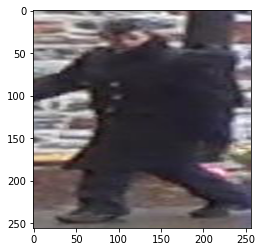

In [30]:
id = 5
print(dataset[id]['img_id'])
show_tensor(dataset[id]['img'])

In [34]:
dataset.train()

In [37]:
dataset.eval()

In [27]:
dataset = DatasetForClassifier("../../datasets/DukeMTMC/", transform, resolution = 128, classes = 700, val_percent = 0.2)
dataset_loader = torch.utils.data.DataLoader(dataset, batch_size = 64, shuffle = True, num_workers = 4)

In [26]:
dataset2 = DatasetForClassifier("../../datasets/JTA_parsed/", transform, resolution = 128, classes = 700, val_percent = 0.2)
dataset_loader2 = torch.utils.data.DataLoader(dataset, batch_size = 64, shuffle = True, num_workers = 4)

In [40]:
len(dataset)

2032

In [41]:
dataset[-1]

{'img': tensor([[[0.6588, 0.6588, 0.6588,  ..., 0.6941, 0.6941, 0.6941],
          [0.6627, 0.6627, 0.6627,  ..., 0.6902, 0.6902, 0.6902],
          [0.6784, 0.6784, 0.6784,  ..., 0.6863, 0.6863, 0.6863],
          ...,
          [0.8510, 0.8510, 0.8510,  ..., 0.8980, 0.8980, 0.8980],
          [0.8549, 0.8549, 0.8549,  ..., 0.9020, 0.9020, 0.9020],
          [0.8588, 0.8588, 0.8588,  ..., 0.9059, 0.9059, 0.9059]],
 
         [[0.7686, 0.7686, 0.7686,  ..., 0.7804, 0.7804, 0.7804],
          [0.7725, 0.7725, 0.7725,  ..., 0.7765, 0.7765, 0.7765],
          [0.7882, 0.7882, 0.7882,  ..., 0.7725, 0.7725, 0.7725],
          ...,
          [0.8980, 0.8980, 0.8980,  ..., 0.9922, 0.9922, 0.9922],
          [0.9020, 0.9020, 0.9020,  ..., 0.9961, 0.9961, 0.9961],
          [0.9059, 0.9059, 0.9059,  ..., 1.0000, 1.0000, 1.0000]],
 
         [[0.5412, 0.5412, 0.5412,  ..., 0.6275, 0.6275, 0.6275],
          [0.5451, 0.5451, 0.5451,  ..., 0.6275, 0.6275, 0.6275],
          [0.5608, 0.5608, 0.5608